In [1]:
!chmod 600 /root/.kaggle/kaggle.json
!pip install --upgrade pip
!pip install kaggle pandas matplotlib scikit-learn

# Project Goal and Overview
The goal of this project is to create a Generative Adversarial Network (GAN) to convert images into the monet style.  To do this, I will use the 300 monet images to perform the training.  There are 300 Monets, and 7000+ photos.



In [2]:
import kaggle
import zipfile
import tensorflow.keras as keras
from keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
import math


from __future__ import absolute_import, division, print_function
import gzip, pickle
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

import requests
from os import getcwd
import tarfile

autotune = tf.data.AUTOTUNE
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

2024-06-02 21:30:32.331161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 21:30:32.331213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 21:30:32.332350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 21:30:32.339092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Description
The data is 2 sets of 256x256x3 color photos.  300 are monet paintings, and ~7000 are just ordinary photos.  Images are in a TFREC (Tensor Flow Record) format, which is convienient ofr easy batching.  

In [3]:
tmp_dir = getcwd() + "/kaggle/tmp/"
input_dir = getcwd() + "/kaggle/input/"
if not os.path.exists(getcwd() + "/kaggle"):
    os.makedirs(getcwd() + "/kaggle")
if not os.path.exists(getcwd() + "/kaggle/tmp"):
    os.makedirs(getcwd() + "/kaggle/tmp")
if not os.path.exists(getcwd() + "/kaggle/tmp/images"):
    os.makedirs(getcwd() + "/kaggle/tmp/images")

In [4]:
if not os.path.exists(getcwd() + "kaggle/input/"):
    !kaggle competitions download -c 'gan-getting-started'
    #!mkdir kaggle
    #!mkdir kaggle/input
    #!mkdir kaggle/input/gan-getting-started
    #!unzip -qq gan-getting-started.zip -d kaggle/input/gan-getting-started
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall(f"{input_dir}gan-getting-started")

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:

def count_files_in_directory(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(
        os.path.join(directory_path, f))]
    # Count the number of files
    file_count = len(files)
    return file_count
directory_path = f'{input_dir}gan-getting-started/monet_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

directory_path = f'{input_dir}gan-getting-started/photo_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Photo Images.')

There are 300 Monet Images.
There are 7038 Photo Images.


# EDA
I did some basic looking at the various images to see what I got.  I also looked at T-SNE and Color Density Plots of the 2 data sets.  

20 Monet Images above 20 Photos


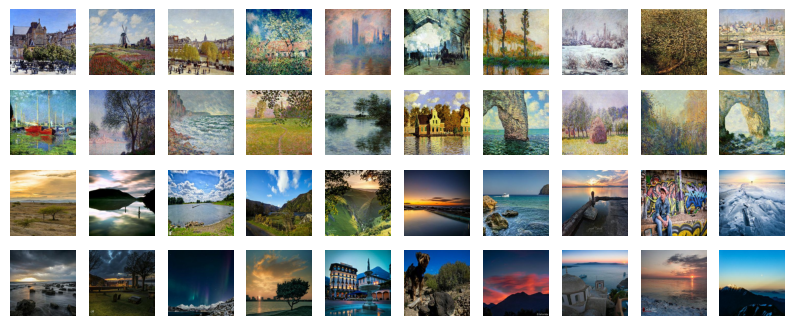

In [6]:
#Generated by Gemini AI but modified to actually work
# Get a list of all the files in the Monet directory
monet_files = os.listdir(f"{input_dir}gan-getting-started/monet_jpg")

# Get a list of all the files in the photo directory
photo_files = os.listdir(f"{input_dir}gan-getting-started/photo_jpg")

# Select 20 random Monet images
random_monet_files = random.sample(monet_files, 20)

# Select 20 random photo images
random_photo_files = random.sample(photo_files, 20)

# Create a 10x2 grid of subplots
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
print("20 Monet Images above 20 Photos")

# Plot the Monet images in the first column

for i, filename in enumerate(random_monet_files):
    img = mpimg.imread(os.path.join(f"{input_dir}/gan-getting-started/monet_jpg", filename))
    axes[math.floor(i%2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2), math.floor(i/2)].axis('off')

## Plot the photo images in the second column
for i, filename in enumerate(random_photo_files):
    img = mpimg.imread(os.path.join(f"{input_dir}gan-getting-started/photo_jpg", filename))
    axes[math.floor(i%2+2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2+2), math.floor(i/2)].axis('off')

# Show the plot
plt.show()


# Data Loading and Batch Sizes
In order to perform faster data loading, I chose to load the tfrec files.  I seleted batch sizes to meet GPU memory limitations.

In [7]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image

def read_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(example, features)
  image = decode_image(example['image'])
  return image
tfrecord_dir = f"{input_dir}gan-getting-started/monet_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
monet_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

tfrecord_dir = f"{input_dir}gan-getting-started/photo_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
photo_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)
print(monet_images_dataset)

print(f"There are {count_elements(monet_images_dataset)} Monet images")
print(f"There are {count_elements(photo_images_dataset)} Photo images")


2024-06-02 21:30:39.414437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:81:00.0, compute capability: 8.9


<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
There are 300 Monet images
There are 7038 Photo images


In [8]:
# https://keras.io/examples/generative/cyclegan/
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0
    #return (img / 127.5)
    #return (img)


def preprocess_train_image(img):
    # Random flip
    print(img)
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [9]:
img_size = 256
image_depth = 3
batch_size = 4
LR = 0.00012
buffer_size = 150

In [10]:
# prompt: split TFRecordDataset into a train and test set 80/20 split


# Apply the preprocessing operations to the training data
monet_train_dataset = (
    monet_images_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply the preprocessing operations to the test data
photo_train_dataset = (
    photo_images_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'Photo Images Count {count_elements(photo_train_dataset)}')

print(f'Monet Images Count {count_elements(monet_train_dataset)}')
all_batches = []
for batch in monet_train_dataset:
    # Convert each batch to a NumPy array and append to the list
    all_batches.append(batch.numpy())
    break
print(all_batches[0].shape)

#for i, img in enumerate(monet_test_dataset.take(1)):
#    #print(f"Image {i}: {img}")
 #   plt.imshow(img[0] * 127.5 + 127.5)
 #   plt.title(f"Image {i}")
#    plt.axis('off')
#    plt.show()

Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)
Photo Images Count 1760
Monet Images Count 75
(4, 256, 256, 3)


#  Starting off the GAN
I used https://keras.io/examples/generative/cyclegan/ as a reference for the initial model build.

In [11]:
# Implementing Instance Normalization due to TFA compatability 
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, gamma_initializer='ones', beta_initializer='zeros'):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer
        self.beta_initializer = beta_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.gamma_initializer,
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.beta_initializer,
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta 

In [12]:


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [13]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [14]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


Gan Monitor prints out 4 pictures for visual feedback every 25 Epochs.

In [16]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 25 != 0:
          return
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train_dataset.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
            img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


# Scoring Code
Copied and modified from https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI.  

This calculates the FID score and will be used in callbacks. I tried for the Modieifed Fid used by Kaggle but could not get it to work.

In [17]:
def create_images_from_predict(num_images):
    for i, img in enumerate(photo_train_dataset.take(num_images)):
        prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
        prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.uint8)  # Convert to uint8
        yield prediction
    print(f"{i+1} Photo Images saved")

def create_dataset_from_predictions(num_images):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_images_from_predict(num_images),
        output_signature=tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
    )
    return dataset.batch(batch_size)
#create_images_from_predict(256)

In [18]:

inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

def compute_embeddings(dataloader):
    image_embeddings = []
    #for _ in tqdm(range(count)):
    #    images = next(iter(dataloader))
    embeddings = inception_model.predict(dataloader)
    image_embeddings.extend(embeddings)
    return np.array(image_embeddings)
    
count = math.ceil(10000/batch_size)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(monet_train_dataset)
#real_image_embeddings = (real_image_embeddings-np.min(
#    real_image_embeddings))/(np.max(
#    real_image_embeddings)-np.min(
#    real_image_embeddings)) 

class fid_score_callback(keras.callbacks.Callback):
    def __init__(self):
        super(fid_score_callback, self).__init__()
        self.inception_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", pooling='avg')
        self.generated_image_embeddings = None

    def compute_embeddings(self, dataloader):
        image_embeddings = []
        embeddings = self.inception_model.predict(dataloader)
        image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    def calculate_fid(self, real_embeddings, generated_embeddings):
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = linalg.sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    def on_epoch_end(self, epoch, logs=None):
        if epoch  % 25 == 0 and epoch != 0:
            self.generated_image_embeddings = self.compute_embeddings(create_dataset_from_predictions(512))
            #self.generated_image_embeddings = (self.generated_image_embeddings - np.min(self.generated_image_embeddings)) / (np.max(self.generated_image_embeddings) - np.min(self.generated_image_embeddings))
            fid = self.calculate_fid(real_image_embeddings, self.generated_image_embeddings)
            print(f'FID score at epoch {epoch}: {fid}')


2024-06-02 21:30:47.507524: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


75/75 [==============================] - 2s 11ms/step


Epoch 1/50


2024-06-02 21:31:25.290270: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f302c009cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-02 21:31:25.290300: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-02 21:31:25.295521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717363885.382663   55116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-06-02 21:31:25.989051: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
20

75/75 [==============================] - 70s 401ms/step - G_loss: 8.5323 - F_loss: 8.6986 - D_X_loss: 0.1999 - D_Y_loss: 0.2019
Epoch 2/50
75/75 [==============================] - 29s 388ms/step - G_loss: 0.8971 - F_loss: 0.9360 - D_X_loss: 0.2419 - D_Y_loss: 0.2405
Epoch 3/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.3931 - F_loss: 0.4226 - D_X_loss: 0.2402 - D_Y_loss: 0.2443
Epoch 4/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.3059 - F_loss: 0.3193 - D_X_loss: 0.2422 - D_Y_loss: 0.2445
Epoch 5/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2796 - F_loss: 0.2931 - D_X_loss: 0.2458 - D_Y_loss: 0.2482
Epoch 6/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2741 - F_loss: 0.2817 - D_X_loss: 0.2479 - D_Y_loss: 0.2482
Epoch 7/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2757 - F_loss: 0.2830 - D_X_loss: 0.2473 - D_Y_loss: 0.2483
Epoch 8/50
75/75 [====================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


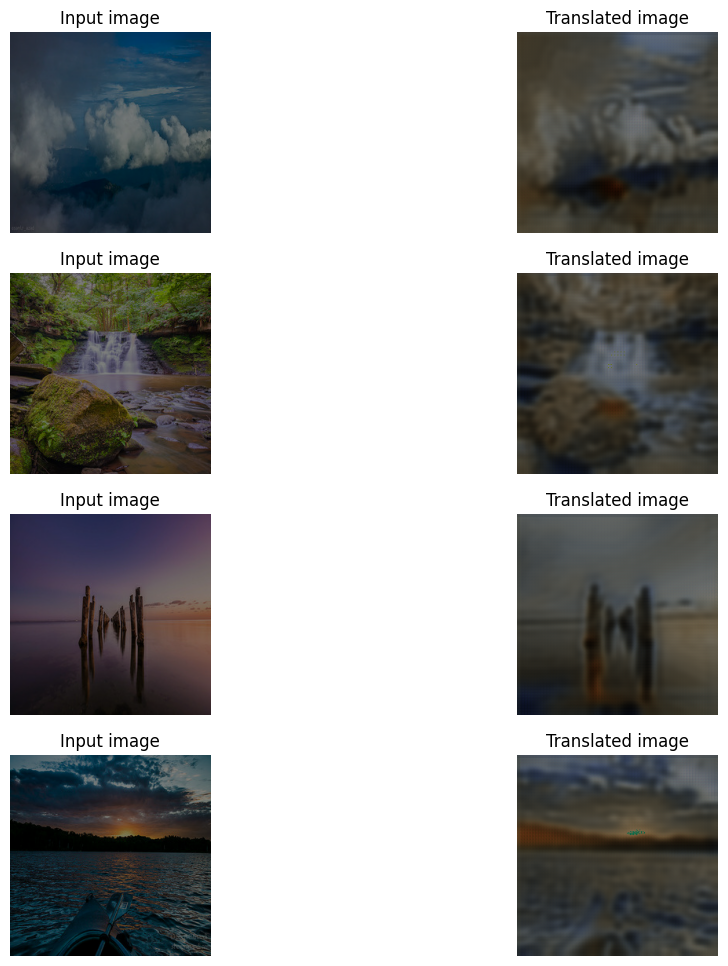

75/75 [==============================] - 31s 407ms/step - G_loss: 0.2641 - F_loss: 0.2693 - D_X_loss: 0.2495 - D_Y_loss: 0.2501
Epoch 26/50
    127/Unknown - 24s 181ms/step512 Photo Images saved
128/128 [==============================] - 24s 181ms/step


2024-06-02 21:44:31.415397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12467338604161568231


FID score at epoch 25: 151939.5305708855
75/75 [==============================] - 218s 3s/step - G_loss: 0.2642 - F_loss: 0.2681 - D_X_loss: 0.2499 - D_Y_loss: 0.2501
Epoch 27/50
75/75 [==============================] - 29s 385ms/step - G_loss: 0.2645 - F_loss: 0.2693 - D_X_loss: 0.2494 - D_Y_loss: 0.2501
Epoch 28/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2639 - F_loss: 0.2677 - D_X_loss: 0.2498 - D_Y_loss: 0.2500
Epoch 29/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2632 - F_loss: 0.2652 - D_X_loss: 0.2501 - D_Y_loss: 0.2501
Epoch 30/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2633 - F_loss: 0.2650 - D_X_loss: 0.2499 - D_Y_loss: 0.2500
Epoch 31/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2628 - F_loss: 0.2650 - D_X_loss: 0.2499 - D_Y_loss: 0.2500
Epoch 32/50
75/75 [==============================] - 29s 386ms/step - G_loss: 0.2626 - F_loss: 0.2650 - D_X_loss: 0.2499 - D_Y_loss: 

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Get the generators
gen_G = get_resnet_generator(filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name="generator_G")
gen_F = filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3,name="discriminator_X")
disc_Y = get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3,name="discriminator_Y")

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)
fid_score_cb = fid_score_callback()
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback, fid_score_cb],
)


# Good Start
The defaults are showing a good starting point.  I'll try to improve on this.  

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(photo_train_dataset.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
    img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show(False)


In [ ]:
!git add .
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "no"
!git push